# Team 6 Project: MINJUSTICIA

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from lifelines import KaplanMeierFitter, CoxPHFitter
from matplotlib import pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50
%matplotlib inline

path = "C:/Users/david/Desktop/ds4a-team6/retomintic/Data_UpdateJune13/reincidencia11junio2020_clean.csv"
df_mj = pd.read_csv(path, sep=",",encoding="utf-8")

# Processing

## 1. Data cleaning and tentative transformations

In [3]:
#Date variables are parsed to datetime
df_mj["FECHA_CAPTURA"] = pd.to_datetime(df_mj["FECHA_CAPTURA"])
df_mj["FECHA_INGRESO"] = pd.to_datetime(df_mj["FECHA_INGRESO"])
df_mj["FECHA_SALIDA"] = pd.to_datetime(df_mj["FECHA_SALIDA"])
#Month and year variables are defined
df_mj["MES_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%m')
df_mj["ANO_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%y')
#Calculations on how much time have the criminal being outside since its last stay in jail
for column in ['FECHA_INGRESO', 'FECHA_SALIDA', 'FECHA_CAPTURA']:
    df_mj = df_mj.sort_values(['INTERNOEN', column], ascending = False)
    
    df_mj['DIAS' + column[5:]] = -1*df_mj[column].diff().copy()

    df_mj.loc[(df_mj.INTERNOEN != df_mj.INTERNOEN.shift(1)) | (df_mj['DIAS' + column[5:]] == np.timedelta64(0)), 
              ['DIAS' + column[5:]]] = datetime.today() - df_mj[column]
    
#It seems that sometimes entering and gettint out is switched, that's why we computed in absolute values
df_mj['DIAS_CONDENA'] = abs(df_mj['FECHA_SALIDA'] - df_mj['FECHA_INGRESO'])
df_mj['DIAS_JUDICIALIZACION'] = df_mj['FECHA_INGRESO'] - df_mj['FECHA_CAPTURA']
df_mj['DIAS_LIBRE'] = df_mj['DIAS_INGRESO'] - df_mj['DIAS_CONDENA']
#The individual finishes its sentence but she's incarcelated inmediately for another crime
df_mj.loc[df_mj.DIAS_CAPTURA < np.timedelta64(0), 'DIAS_CAPTURA'] = np.timedelta64(0)
df_mj.loc[df_mj.DIAS_INGRESO < np.timedelta64(0), 'DIAS_INGRESO'] = np.timedelta64(0)
df_mj.loc[df_mj.DIAS_LIBRE < np.timedelta64(0), 'DIAS_LIBRE'] = np.timedelta64(0)
#The individual is still on jail
df_mj.loc[df_mj['DIAS_LIBRE'].isnull(), 'DIAS_LIBRE'] = np.timedelta64(0)

#Timedelta variables are parsed to integer variables
df_mj[['DIAS_CONDENA', 'DIAS_LIBRE', 'DIAS_INGRESO']] = df_mj[['DIAS_CONDENA', 'DIAS_LIBRE', 'DIAS_INGRESO']].apply(lambda x: x.dt.days, axis = 0)

#Find the last date the criminal went out the jail, so that these observations are marked as censored
last_df = df_mj[['INTERNOEN', 'FECHA_INGRESO']].groupby('INTERNOEN').apply(lambda x: x.sort_values('FECHA_INGRESO', ascending = False).head(1)).reset_index(drop = True)
#Censored
last_df['CENSURADO_LIBRES'] = 0
df_mj = df_mj.merge(last_df, on = ['INTERNOEN', 'FECHA_INGRESO'], how = 'left')
#Event
df_mj.loc[df_mj['CENSURADO_LIBRES'].isnull(), 'CENSURADO_LIBRES'] = 1
#All criminals that haven't got out of jail yet have zero days out and they are not censored.
df_mj.loc[df_mj['FECHA_SALIDA'].isnull(), 'CENSURADO_LIBRES'] = 1
#Turned censored variables to integers instead of float
df_mj['CENSURADO_LIBRES'] = df_mj['CENSURADO_LIBRES'].astype('int64')

#We create a variable to count the amount of times the individual re-entered in jail
df_mj = df_mj.merge(df_mj.drop_duplicates(['INTERNOEN', 'FECHA_INGRESO']).groupby(['INTERNOEN']).size().reset_index(name = 'NUMERO_REINCIDENCIAS'), on = 'INTERNOEN', how = 'left')

#We dropped SITUACION_JURIDICA and REINCIDENTE as both columns are constants
df_mj = df_mj.drop(columns = ['SITUACION_JURIDICA', 'REINCIDENTE'])

## 2. Data exploration

In [4]:
# First exploration on data
for column in df_mj.columns:
    print(f'''
    ------------------------------------------------------
                          {column}
    ------------------------------------------------------
    ''')
    print(df_mj[column].describe())


    ------------------------------------------------------
                          INTERNOEN
    ------------------------------------------------------
    
count                                       142899
unique                                       78841
top       71D8863489582B956956B3E244CF97F629E190F8
freq                                            16
Name: INTERNOEN, dtype: object

    ------------------------------------------------------
                          DELITO
    ------------------------------------------------------
    
count     142899
unique       259
top        HURTO
freq       53145
Name: DELITO, dtype: object

    ------------------------------------------------------
                          TITULO_DELITO
    ------------------------------------------------------
    
count                             142899
unique                                25
top       CONTRA EL PATRIMONIO ECONOMICO
freq                               56860
Name: TITULO_DELITO, dty

count          140108
unique            122
top       BOGOTA D.C.
freq            19008
Name: MPIO_ESTABLECIMIENTO, dtype: object

    ------------------------------------------------------
                          REGIONAL
    ------------------------------------------------------
    
count      142899
unique          6
top       CENTRAL
freq        51092
Name: REGIONAL, dtype: object

    ------------------------------------------------------
                          ESTADO
    ------------------------------------------------------
    
count     142899
unique         2
top         Baja
freq       96002
Name: ESTADO, dtype: object

    ------------------------------------------------------
                          MES_INGRESO_INT
    ------------------------------------------------------
    
count     142899
unique        12
top           05
freq       13633
Name: MES_INGRESO_INT, dtype: object

    ------------------------------------------------------
                         

### 2.1 Discrete variables

No handles with labels found to put in legend.


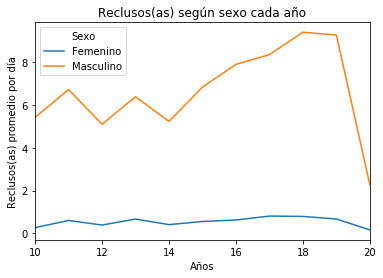

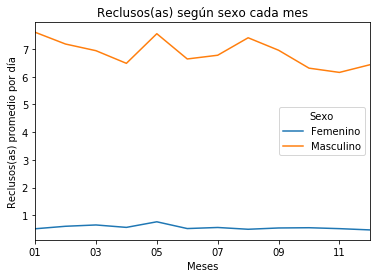

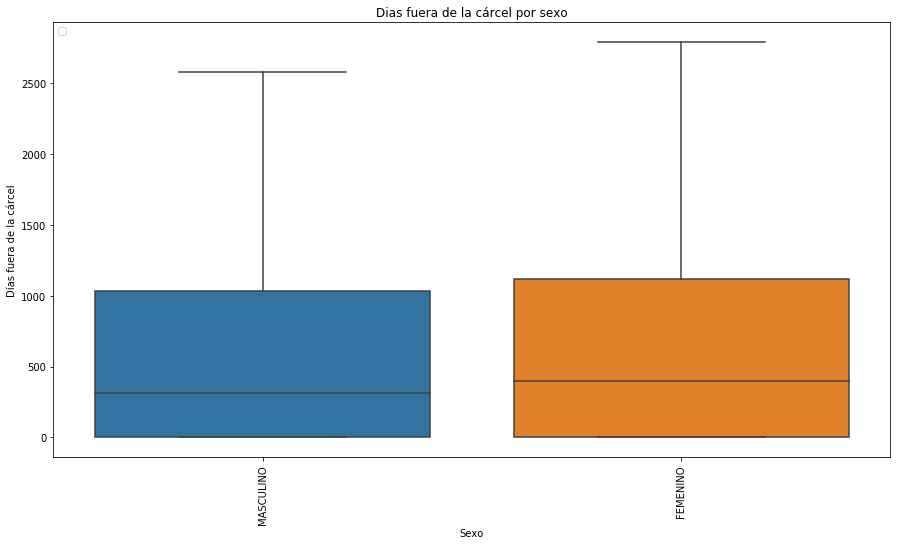

In [5]:
ano = 11
df_genero = df_mj.loc[df_mj.duplicated(['INTERNOEN', 'ANO_INGRESO_INT']), ['GENERO', 'ANO_INGRESO_INT', 'INTERNOEN']].copy()
df_genero['value'] = 1
df_genero['GENERO'].replace({'FEMENINO':'Femenino', 'MASCULINO':'Masculino'}, inplace = True)
df_genero.columns = ['Sexo', 'ANO_INGRESO_INT', 'INTERNOEN', 'value']
df_genero = df_genero.pivot_table(values = 'value', index = ['INTERNOEN', 'ANO_INGRESO_INT'], columns = 'Sexo').fillna(0)

plot = df_genero.reset_index().groupby('ANO_INGRESO_INT').sum()
plot['Femenino'] = plot['Femenino']/365
plot['Masculino'] = plot['Masculino']/365
ax = plot.plot()
ax.set_xlabel('Años');
ax.set_ylabel('Reclusos(as) promedio por día');
ax.set_title('Reclusos(as) según sexo cada año');



df_genero = df_mj.loc[df_mj.duplicated(['INTERNOEN', 'MES_INGRESO_INT']), ['GENERO', 'MES_INGRESO_INT', 'INTERNOEN']].copy()
df_genero['value'] = 1
df_genero['GENERO'].replace({'FEMENINO':'Femenino', 'MASCULINO':'Masculino'}, inplace = True)
df_genero.columns = ['Sexo', 'MES_INGRESO_INT', 'INTERNOEN', 'value']
df_genero = df_genero.pivot_table(values = 'value', index = ['INTERNOEN', 'MES_INGRESO_INT'], columns = 'Sexo').fillna(0)

plot = df_genero.reset_index().groupby('MES_INGRESO_INT').sum()
plot['Femenino'] = plot['Femenino']/[x*ano for x in [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]
plot['Masculino'] = plot['Masculino']/[x*ano for x in [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]
ax = plot.plot()
ax.set_xlabel('Meses');
ax.set_ylabel('Reclusos(as) promedio por día');
ax.set_title('Reclusos(as) según sexo cada mes');



fig, ax = plt.subplots(figsize=(15, 8))
m = sns.boxplot(
    x='GENERO',
    y='DIAS_LIBRE',
    data=df_mj.sort_values('FECHA_INGRESO').loc[df_mj.duplicated('INTERNOEN', 'last'), ['GENERO', 'DIAS_LIBRE']],
    orient='vertical',
    showfliers=False,
)
plt.legend(loc='upper left');
plt.title('Dias fuera de la cárcel por sexo');
plt.xticks(rotation=90);
plt.xlabel('Sexo');
plt.ylabel('Días fuera de la cárcel');

No handles with labels found to put in legend.
No handles with labels found to put in legend.


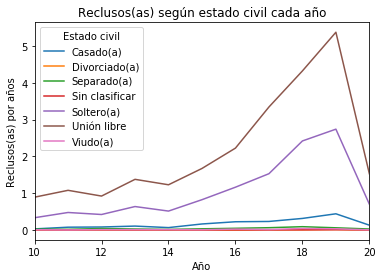

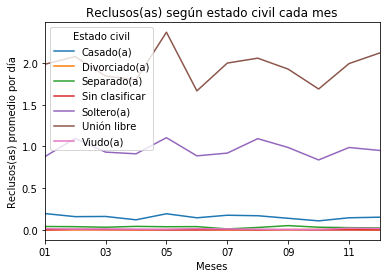

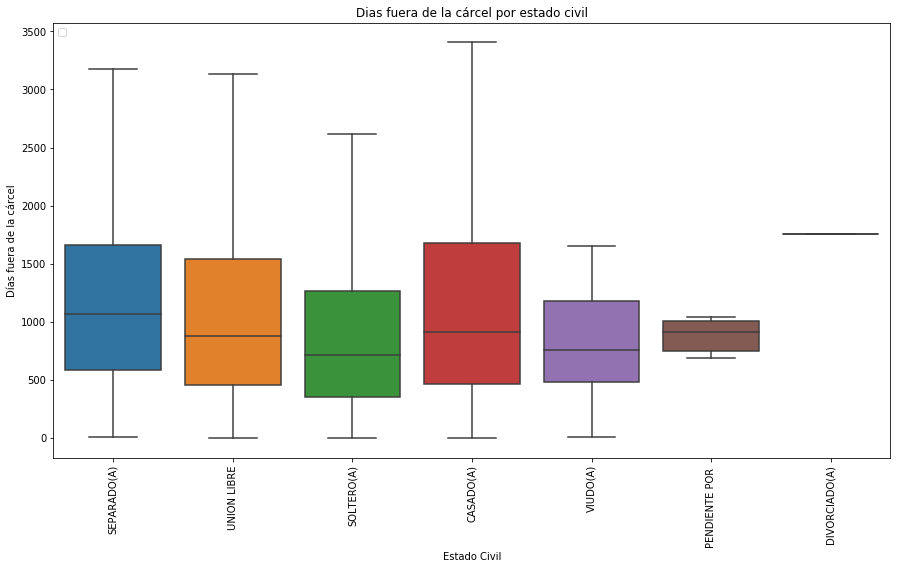

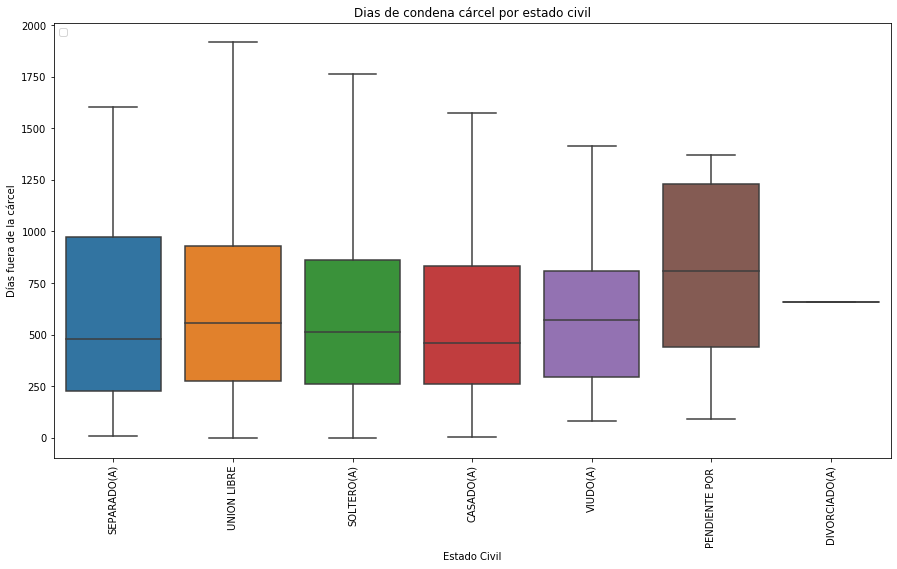

In [6]:
df_casado = df_mj.loc[df_mj.duplicated(['INTERNOEN', 'ANO_INGRESO_INT']), ['ESTADO_CIVIL', 'ANO_INGRESO_INT', 'INTERNOEN']].copy()
df_casado['value'] = 1

df_casado['ESTADO_CIVIL'].replace({'UNION LIBRE':'Unión libre', 'SOLTERO(A)':'Soltero(a)', 'CASADO(A)':'Casado(a)', 
                                   'SEPARADO(A)':'Separado(a)', 'VIUDO(A)':'Viudo(a)', 'PENDIENTE POR ':'Sin clasificar',
                                   'DIVORCIADO(A)':'Divorciado(a)'}, inplace = True)
df_casado.columns = ['Estado civil', 'ANO_INGRESO_INT', 'INTERNOEN', 'value']
df_casado = df_casado.pivot_table(values = 'value', index = ['INTERNOEN', 'ANO_INGRESO_INT'], columns = 'Estado civil').fillna(0)

plot = df_casado.reset_index().groupby('ANO_INGRESO_INT').sum()
for value in plot.columns:
    plot[value] = plot[value]/365
ax = plot.plot()
ax.set_xlabel('Año');
ax.set_ylabel('Reclusos(as) por años');
ax.set_title('Reclusos(as) según estado civil cada año');




df_casado = df_mj.loc[df_mj.duplicated(['INTERNOEN', 'DIAS_LIBRE']), ['ESTADO_CIVIL', 'MES_INGRESO_INT', 'INTERNOEN']].copy()
df_casado['value'] = 1
df_casado['ESTADO_CIVIL'].replace({'UNION LIBRE':'Unión libre', 'SOLTERO(A)':'Soltero(a)', 'CASADO(A)':'Casado(a)', 
                                   'SEPARADO(A)':'Separado(a)', 'VIUDO(A)':'Viudo(a)', 'PENDIENTE POR ':'Sin clasificar',
                                   'DIVORCIADO(A)':'Divorciado(a)'}, inplace = True)
df_casado.columns = ['Estado civil', 'MES_INGRESO_INT', 'INTERNOEN', 'value']
df_casado = df_casado.pivot_table(values = 'value', index = ['INTERNOEN', 'MES_INGRESO_INT'], columns = 'Estado civil').fillna(0)
plot = df_casado.reset_index().groupby('MES_INGRESO_INT').sum()
for value in plot.columns:
    plot[value] = plot[value]/[x*ano for x in [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]
ax = plot.plot()
ax.set_xlabel('Meses');
ax.set_ylabel('Reclusos(as) promedio por día');
ax.set_title('Reclusos(as) según estado civil cada mes');


datos = df_mj.sort_values('FECHA_INGRESO').loc[df_mj.duplicated('INTERNOEN', 'last'), ['ESTADO_CIVIL', 'DIAS_LIBRE']]
fig, ax = plt.subplots(figsize=(15, 8))
m = sns.boxplot(
    x='ESTADO_CIVIL',
    y='DIAS_LIBRE',
    data = datos[datos['DIAS_LIBRE'] > 0],
    orient='vertical',
    showfliers=False,
)
plt.legend(loc='upper left');
plt.title('Dias fuera de la cárcel por estado civil');
plt.xticks(rotation=90);
plt.xlabel('Estado Civil');
plt.ylabel('Días fuera de la cárcel');

datos = df_mj.sort_values('FECHA_INGRESO').loc[df_mj.duplicated('INTERNOEN', 'last'), ['ESTADO_CIVIL', 'DIAS_CONDENA']]
fig, ax = plt.subplots(figsize=(15, 8))
m = sns.boxplot(
    x='ESTADO_CIVIL',
    y='DIAS_CONDENA',
    data = datos,
    orient='vertical',
    showfliers=False,
)
plt.legend(loc='upper left');
plt.title('Dias de condena cárcel por estado civil');
plt.xticks(rotation=90);
plt.xlabel('Estado Civil');
plt.ylabel('Días fuera de la cárcel');

No handles with labels found to put in legend.


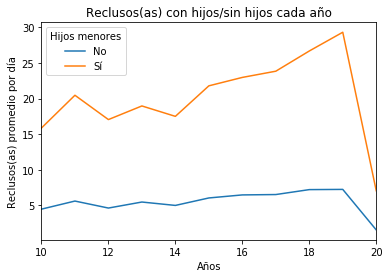

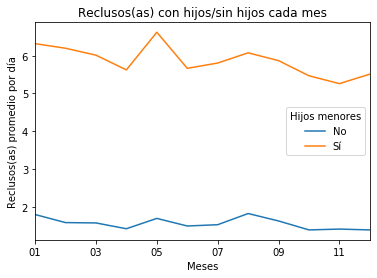

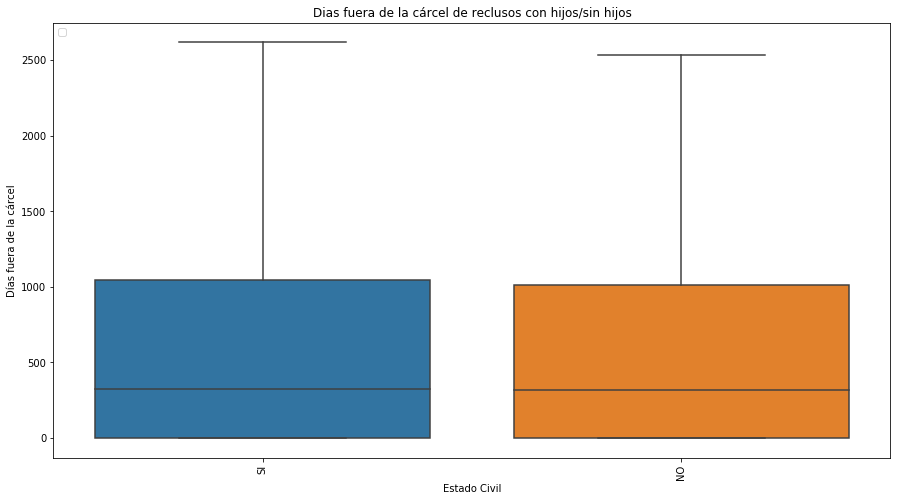

In [7]:
df_HIJOS_MENORES = df_mj.loc[~df_mj.duplicated(['INTERNOEN', 'ANO_INGRESO_INT']), ['HIJOS_MENORES', 'ANO_INGRESO_INT', 'INTERNOEN']].copy()
df_HIJOS_MENORES['value'] = 1
df_HIJOS_MENORES['HIJOS_MENORES'].replace({'SI':'Sí', 'NO':'No'}, inplace = True)
df_HIJOS_MENORES.columns = ['Hijos menores', 'ANO_INGRESO_INT', 'INTERNOEN', 'value']
df_HIJOS_MENORES = df_HIJOS_MENORES.pivot_table(values = 'value', index = ['INTERNOEN', 'ANO_INGRESO_INT'], columns = 'Hijos menores').fillna(0)

plot = df_HIJOS_MENORES.reset_index().groupby('ANO_INGRESO_INT').sum()
plot['Sí'] = plot['Sí']/365
plot['No'] = plot['No']/365
ax = plot.plot()
ax.set_xlabel('Años');
ax.set_ylabel('Reclusos(as) promedio por día');
ax.set_title('Reclusos(as) con hijos/sin hijos cada año');



df_HIJOS_MENORES = df_mj.loc[df_mj.duplicated(['INTERNOEN', 'MES_INGRESO_INT']), ['HIJOS_MENORES', 'MES_INGRESO_INT', 'INTERNOEN']].copy()
df_HIJOS_MENORES['value'] = 1
df_HIJOS_MENORES['HIJOS_MENORES'].replace({'SI':'Sí', 'NO':'No'}, inplace = True)
df_HIJOS_MENORES.columns = ['Hijos menores', 'MES_INGRESO_INT', 'INTERNOEN', 'value']
df_HIJOS_MENORES = df_HIJOS_MENORES.pivot_table(values = 'value', index = ['INTERNOEN', 'MES_INGRESO_INT'], columns = 'Hijos menores').fillna(0)

plot = df_HIJOS_MENORES.reset_index().groupby('MES_INGRESO_INT').sum()
plot['Sí'] = plot['Sí']/[x*ano for x in [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]
plot['No'] = plot['No']/[x*ano for x in [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]
ax = plot.plot()
ax.set_xlabel('Meses');
ax.set_ylabel('Reclusos(as) promedio por día');
ax.set_title('Reclusos(as) con hijos/sin hijos cada mes');


fig, ax = plt.subplots(figsize=(15, 8))
m = sns.boxplot(
    x='HIJOS_MENORES',
    y='DIAS_LIBRE',
    data=df_mj.sort_values('FECHA_INGRESO').loc[df_mj.duplicated('INTERNOEN', 'last'), ['HIJOS_MENORES', 'DIAS_LIBRE']],
    orient='vertical',
    showfliers=False,
)
plt.legend(loc='upper left');
plt.title('Dias fuera de la cárcel de reclusos con hijos/sin hijos');
plt.xticks(rotation=90);
plt.xlabel('Estado Civil');
plt.ylabel('Días fuera de la cárcel');

In [8]:
pd.crosstab(df_mj['GENERO'], df_mj['HIJOS_MENORES'])

HIJOS_MENORES,NO,SI
GENERO,,
FEMENINO,764,10650
MASCULINO,29273,102212


In [9]:
pd.crosstab(df_mj['GENERO'], df_mj['ESTADO_CIVIL'])

ESTADO_CIVIL,CASADO(A),DIVORCIADO(A),PENDIENTE POR,RELIGIOSO(A),SEPARADO(A),SOLTERO(A),UNION LIBRE,VIUDO(A)
GENERO,,,,,,,,
FEMENINO,125,10,3,0,122,1483,2286,99
MASCULINO,2709,32,22,1,639,19505,35640,134


In [10]:
pd.crosstab(df_mj['HIJOS_MENORES'], df_mj['ESTADO_CIVIL'])

ESTADO_CIVIL,CASADO(A),DIVORCIADO(A),PENDIENTE POR,RELIGIOSO(A),SEPARADO(A),SOLTERO(A),UNION LIBRE,VIUDO(A)
HIJOS_MENORES,,,,,,,,
NO,245,6,8,1,44,7121,5530,19
SI,2589,36,17,0,717,13867,32396,214


In [11]:
pd.crosstab(df_mj['HIJOS_MENORES'], df_mj['GENERO'])

GENERO,FEMENINO,MASCULINO
HIJOS_MENORES,,
NO,764,29273
SI,10650,102212


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


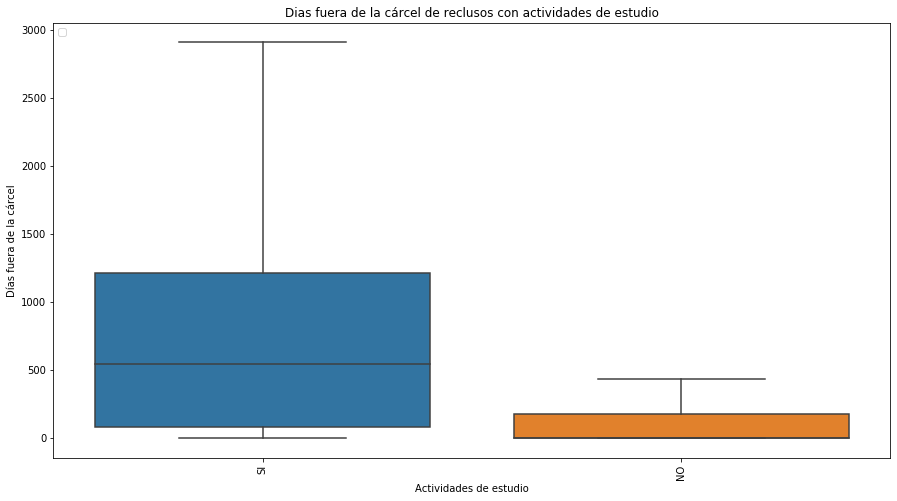

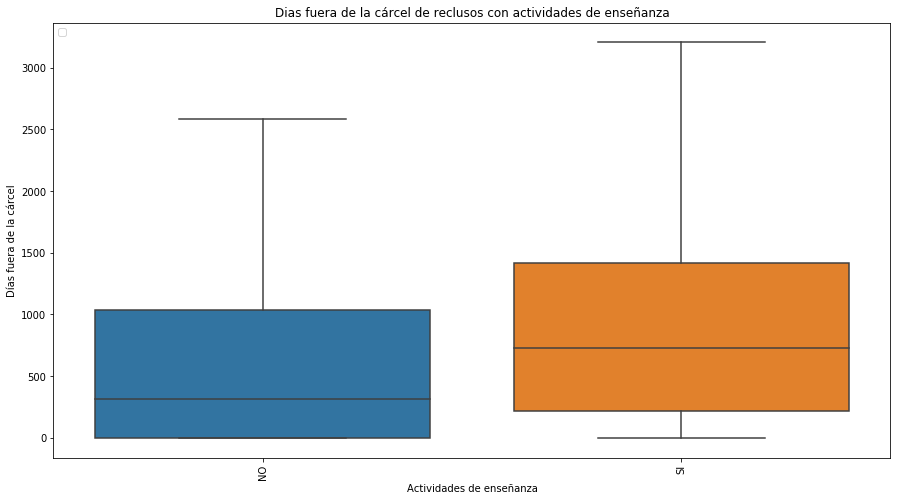

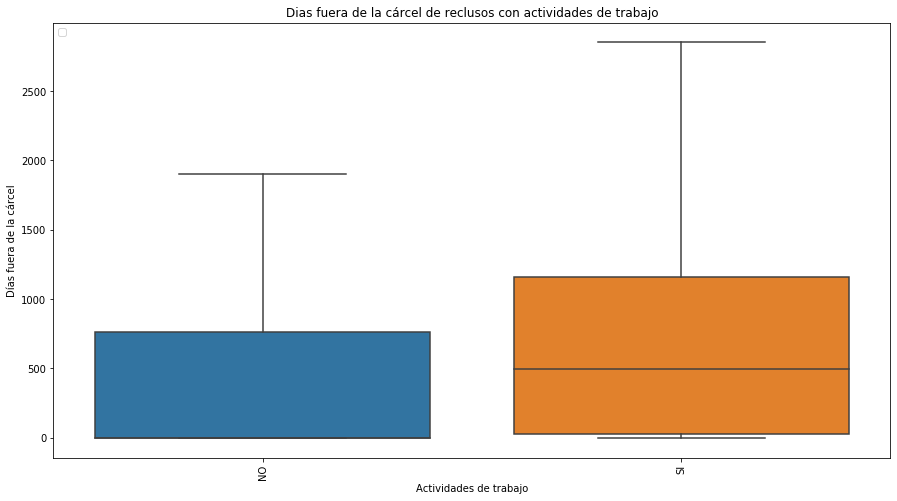

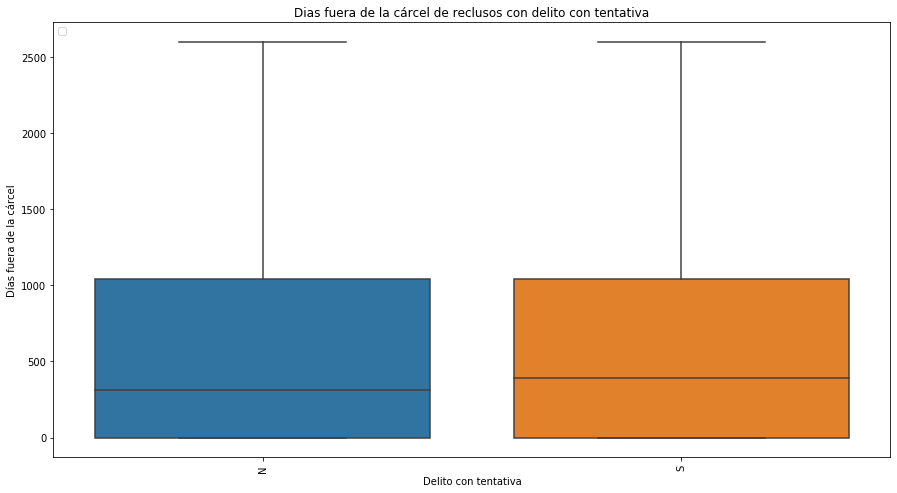

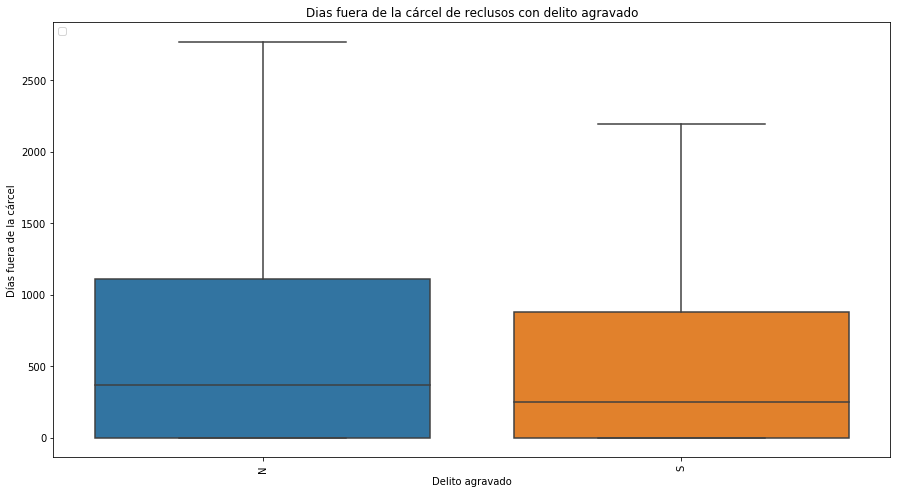

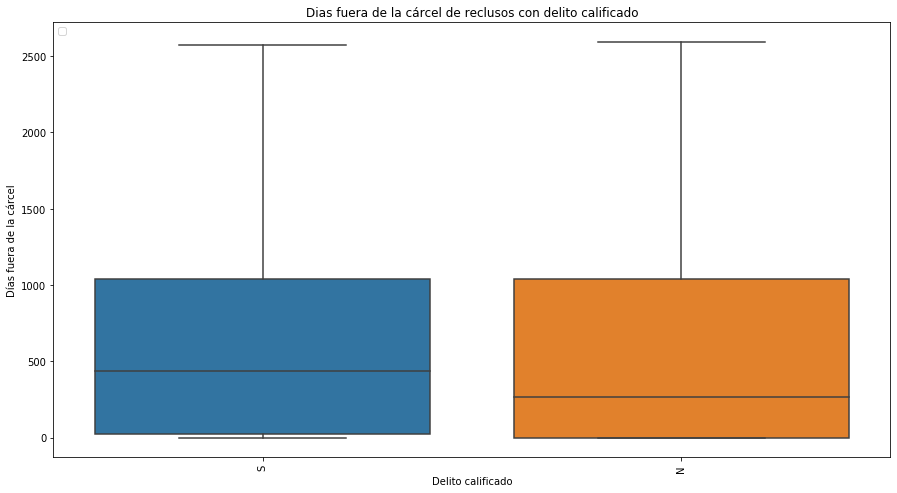

In [12]:
descripcion = ['Actividades de estudio', 'Actividades de enseñanza', 'Actividades de trabajo', 
               'Delito con tentativa', 'Delito agravado', 'Delito calificado']
i = 0
for actividades in ['ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA', 'ACTIVIDADES_TRABAJO', 'TENTATIVA', 'AGRAVADO', 'CALIFICADO']:
    fig, ax = plt.subplots(figsize=(15, 8))
    m = sns.boxplot(
        x=actividades,
        y='DIAS_LIBRE',
        data=df_mj.sort_values('FECHA_INGRESO').loc[df_mj.duplicated('INTERNOEN', 'last'), [actividades, 'DIAS_LIBRE']],
        orient='vertical',
        showfliers=False,
    )
    plt.legend(loc='upper left');
    plt.title(f'Dias fuera de la cárcel de reclusos con {descripcion[i][0].lower() + descripcion[i][1:]}');
    plt.xticks(rotation=90);
    plt.xlabel(descripcion[i]);
    plt.ylabel('Días fuera de la cárcel');
    i+=1

## 2.2 Continuous variables

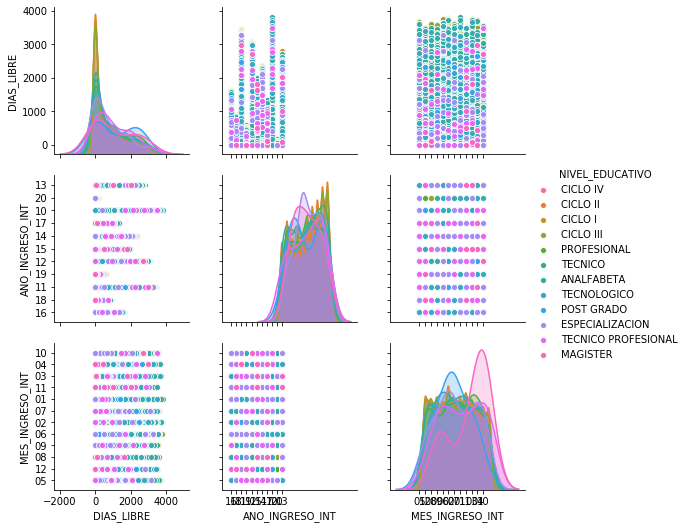

In [13]:
g = sns.pairplot(df_mj[['DIAS_CAPTURA', 'DIAS_LIBRE', 'DIAS_JUDICIALIZACION', 
                        'ANO_INGRESO_INT', 'MES_INGRESO_INT', 'NIVEL_EDUCATIVO']],
                 hue = 'NIVEL_EDUCATIVO') 

## 5. Survival analysis on days out of jail 

In [33]:
df_km = df_mj[['INTERNOEN', 'FECHA_INGRESO', 'DIAS_LIBRE', 'CENSURADO_LIBRES', 'ANO_INGRESO_INT', 'NUMERO_REINCIDENCIAS']].groupby('INTERNOEN').apply(lambda x: x.sort_values('FECHA_INGRESO', ascending = False).tail(1)).reset_index(drop = True)

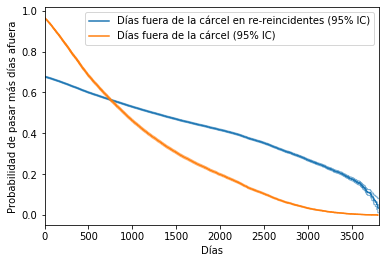

In [34]:
for i in [0, 1]:
    kmf = KaplanMeierFitter()
    kmf.fit(df_km.loc[df_km['NUMERO_REINCIDENCIAS']>i,'DIAS_LIBRE'], df_km.loc[df_km['NUMERO_REINCIDENCIAS']>i, 'CENSURADO_LIBRES'])
    
    if i == 0:
        ax = kmf.plot(ci_force_lines=True, label='Días fuera de la cárcel en re-reincidentes (95% IC)')
    else:
        ax = kmf.plot(ci_force_lines=True, label='Días fuera de la cárcel (95% IC)')
    ax.set_xlabel('Días');
    ax.set_ylabel('Probabilidad de pasar más días afuera');


        -----------------------------------------------------
                         2018
        -----------------------------------------------------
        


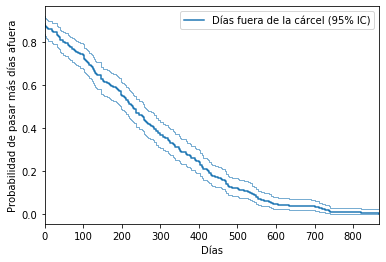


        -----------------------------------------------------
                         2013
        -----------------------------------------------------
        


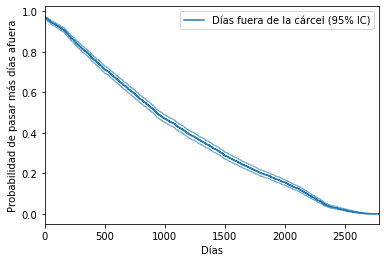


        -----------------------------------------------------
                         2014
        -----------------------------------------------------
        


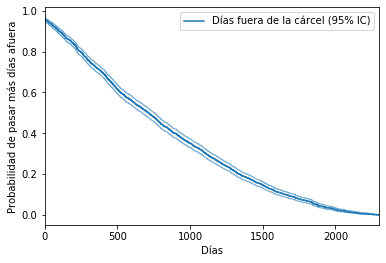


        -----------------------------------------------------
                         2017
        -----------------------------------------------------
        


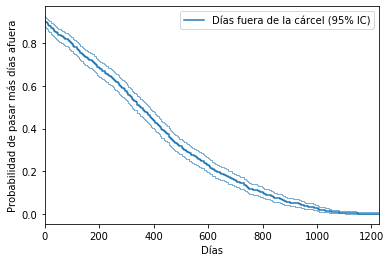


        -----------------------------------------------------
                         2016
        -----------------------------------------------------
        


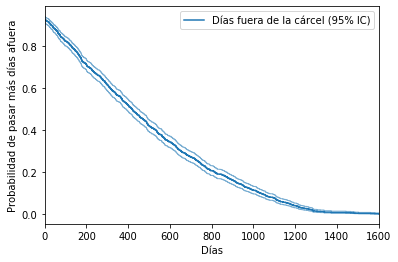


        -----------------------------------------------------
                         2010
        -----------------------------------------------------
        


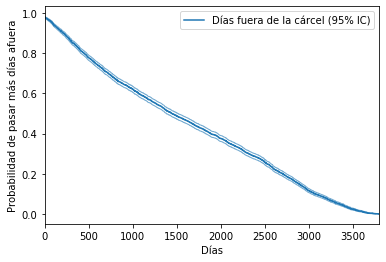


        -----------------------------------------------------
                         2011
        -----------------------------------------------------
        


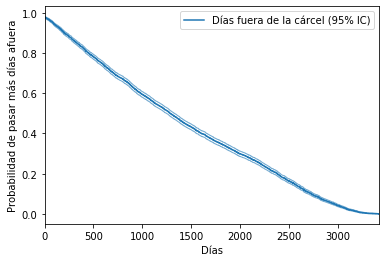


        -----------------------------------------------------
                         2015
        -----------------------------------------------------
        


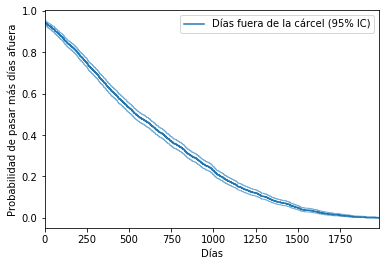


        -----------------------------------------------------
                         2012
        -----------------------------------------------------
        


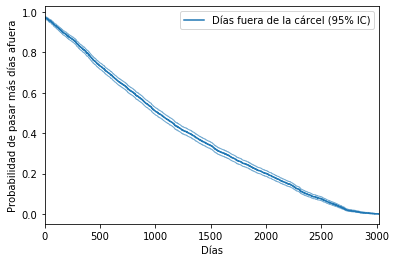

In [35]:
for ano in df_km.ANO_INGRESO_INT.unique():
    if ano != '19' and ano != '20':
        kmf = KaplanMeierFitter()
        kmf.fit(df_km.loc[(df_km['ANO_INGRESO_INT'] == ano) & 
                          (df_km['NUMERO_REINCIDENCIAS']>1),'DIAS_LIBRE'], 
                 df_km.loc[(df_km['ANO_INGRESO_INT'] == ano) & 
                           (df_km['NUMERO_REINCIDENCIAS']>1), 'CENSURADO_LIBRES'])
    
    
        print(f"""
        -----------------------------------------------------
                         20{ano}
        -----------------------------------------------------
        """)
        ax = kmf.plot(ci_force_lines=True, label='Días fuera de la cárcel (95% IC)')
        ax.set_xlabel('Días');
        ax.set_ylabel('Probabilidad de pasar más días afuera');
        plt.show()
